In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [20]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,  inspect

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\ulyan\AppData\Local\Temp\ipykernel_25116\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [24]:
# View all of the classes that automap found
e_inspect = inspect(engine)
e_inspect.get_table_names()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement  = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

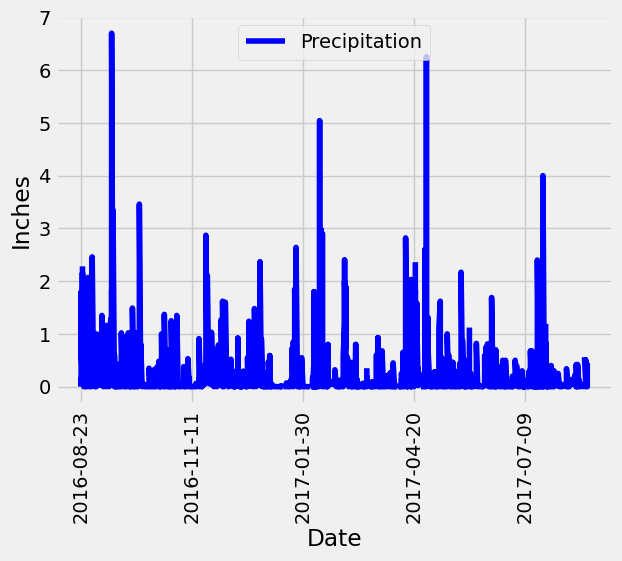

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date_str = recent_date[0]
recent_date_norm = dt.datetime.strptime(recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_date = recent_date_norm - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
year_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
year_scores_df = pd.DataFrame(year_scores, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
year_scores_sort_df = year_scores_df.sort_values(by="Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.tight_layout()
plt.plot(year_scores_df['Date'], year_scores_df['Precipitation'], color='blue', label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.legend(loc='upper center')
#Could only find this method to display 5 dates (imported MaxNLocator from matplotlib)
plt.gca().xaxis.set_major_locator(MaxNLocator(6))
plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = year_scores_df['Precipitation'].describe()
precipitation_summary_df = pd.DataFrame(precipitation_summary)
precipitation_summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number of stations in the dataset
station_n = session.query(Measurement.station).distinct().count()
station_n

9

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
                              group_by(Measurement.station).\
                              order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_act_id = active_stations[0][0]
temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
               filter(Measurement.station == most_act_id).\
               all()
temps

[(54.0, 85.0, 71.66378066378067)]

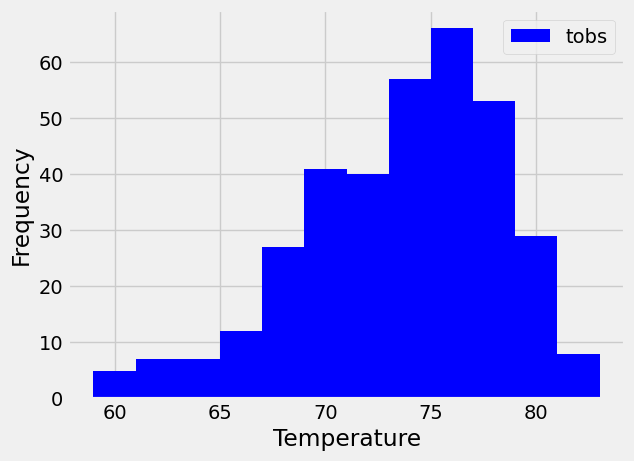

In [94]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observ_12 = session.query(Measurement.tobs).\
    filter(Measurement.station == most_act_id).\
    filter(Measurement.date >= one_year_date).\
        order_by(Measurement.date).all()

temperatures = [temp[0] for temp in temp_observ_12]

plt.hist(temperatures, bins=12, color='blue', label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [95]:
# Close Session
session.close()